In [ ]:
print(tf.__version__)

2.12.0


## Imports (als erstes ausführen!)

In [1]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

import tensorflow_datasets as tfds
import itertools
import time

import matplotlib.pyplot as plt

## Funktionen (als zweites ausführen!)

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

idx = np.argsort(y_train)
x_train_sorted = x_train[idx]
y_train_sorted = y_train[idx]


11490434/11490434 [==============================] - 0s 0us/step


In [3]:
def create_clients_iid(x_train_sorted, y_train_sorted, num_clients=10):
  '''
  return: Gibt ein Dictionary zurück, in der pro Client die Daten in data shards gespeichert werden. Die Daten sind iid.
  args: x_train_sorted: nach Label-Klasse sortierte Liste von numpy arrays der Trainingsdaten
        y_train_sorted: Liste der zu x_train_sorted gehörigen Labels (entsprechend auch sortiert)
        num_clients: Anzahl an Clients im Federated Network
  '''
  #Ertellt ein Dictionary von Clients, wobei Anzahl=num_clients
  client_names = ['clients_{}'.format(i+1) for i in range(num_clients)]

  # Bestimmt jeweils die erste Position einer Label-Klasse (Hinweis: die Daten sind sortiert)
  number_begin_index = []
  for i in range(10):
    number_begin_index.append(np.where(y_train_sorted==i)[0][0])

  # Die Listen werden verlinkt
  data_combined = list(zip(x_train_sorted, y_train_sorted))


  #Bestimmt die Anzahl an Daten, die jeder Client pro Label-Klasse erhält (5421 ist die Anzahl an '5' in MNIST) 
  size = (5421)//num_clients
  shards = 10*[0] 
  for label in range(10):
      shards[label] =  [data_combined[int(number_begin_index[label]+ size*(client_index) ):int(number_begin_index[label]+size*(client_index+1))] for client_index in range(num_clients)] 


  return {client_names[client_index]: [shards[label][client_index] for label in range(10)] for client_index in range(num_clients) }



def create_clients_non_iid(x_train_sorted, y_train_sorted, num_clients=10, dirichlet_param=0.3):
  '''
  return: Gibt ein Dictionary zurück, in der pro Client die Daten in data shards gespeichert werden. Die Daten sind non-iid.
  args: x_train_sorted: nach Label-Klasse sortierte Liste von numpy arrays der Trainingsdaten
        y_train_sorted: Liste der zu x_train_sorted gehörigen Labels (entsprechend auch sortiert)
        num_clients: Anzahl an Clients im Federated Network
        dirichlet_param: gibt den Parameter>0 der Dirichlet-Verteilung an, mit der die Verteilung der Label-Klassen bestimmt wird. Je größer dirichlet_param, desto näher an iid
  '''
  #Ertellt ein Dictionary von Clients, wobei Anzahl=num_clients
  client_names = ['clients_{}'.format(i+1) for i in range(num_clients)]

  # Bestimmt jeweils die erste Position einer Label-Klasse (Hinweis: die Daten sind sortiert)
  number_begin_index = []
  for i in range(10):
    number_begin_index.append(np.where(y_train_sorted==i)[0][0])

  # Die Listen werden verlinkt
  data_combined = list(zip(x_train_sorted, y_train_sorted))

  # Hier wird geprüft, ob durch die Clients jede Label-Klasse (global gesehen) häufig genug vorkommen wird, wenn nein wird die Verteilung neu generiert.
  #Damit soll ermöglicht werden, dass die Menge an genutzten Trainingsdaten hoch gehalten wird
  t = True
  while t:
    data_ratios = np.random.dirichlet(dirichlet_param*np.ones(10), num_clients).transpose()
    max_number = max([sum(data_ratios[i]) for i in range(10)]) / num_clients
    min_number = min([sum(data_ratios[i]) for i in range(10)]) / num_clients
    if max_number<0.12 and min_number>0.06:
      t = False

  #Bestimmt einen Skalierungsfaktor, damit der Client die Korrekte Anzahl an Label-Klassen erhält und möglichst viele Label-Klassen genutzt werden 
  scale_size = ((5421*10)*0.1)//(num_clients*max_number) 
  data_ratios_scaled = (data_ratios*scale_size).round() 


  #Bestimmt die Anzahl an Daten, die jeder Client pro Label-Klasse erhält (5421 ist die Anzahl an '5' in MNIST) 
  shards = 10*[0] 
  for label in range(10):
      shards[label] =  [data_combined[int(number_begin_index[label]+sum(data_ratios_scaled[label][0:client_index])):int(number_begin_index[label]+sum(data_ratios_scaled[label][0:client_index+1]))] for client_index in range(num_clients)] 


  return {client_names[client_index]: [shards[label][client_index] for label in range(10)] for client_index in range(num_clients) }




In [4]:
def get_clients_batched(clients,B_size):
  #Die bisher noch sortierten Daten im Dictionary werden in dieser Funktion in ein neues Dictionary bespeichert, wobei die Daten diesmal gemischt und in Batches der Größe B_size aufgeteilt werden
  clients_batched = dict()
  for(client_name,data) in clients.items():
    new_data = []
    for label in range(10):
      new_data.extend(data[label])
    clients_batched[client_name] =  batch_data(new_data,B_size)
  return clients_batched

def get_clients_unbatched(clients):
  #Die bisher noch sortierten Daten im Dictionary werden in dieser Funktion in ein neues Dictionary bespeichert, wobei die Daten diesmal gemischt werden (Ohne Aufteilung in Batches)
  clients_batched = dict()
  for(client_name,data) in clients.items():
    new_data = []
    for label in range(10):
      new_data.extend(data[label])
    clients_batched[client_name] =  unbatch_data(new_data)
  return clients_batched



def unbatch_data(data_shard):
  '''
  Takes in a clients data shard and create a tfds object off it
  args: shards: a data, label constituting a client's data shard
  return:
        tfds object tensorflow dataset
  '''
  #seperate shard into data and label lists
  data, label = zip(*data_shard)
  dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
  return dataset.shuffle(len(label)).batch(len(data))
  
def batch_data(data_shard, bs=32):
  '''
  Takes in a clients data shard and create a tfds object off it
  args: shards: a data, label constituting a client's data shard
        bs: batch size
  return:
        tfds object tensorflow dataset
  '''
  #seperate shard into data and label lists
  data, label = zip(*data_shard)
  dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
  return dataset.shuffle(len(label)).batch(bs)


In [5]:


def weight_scalling_factor(clients_dict, active_clients, client_name):
  '''  '''
  #Ermittle Batch Size bs
  bs = list(clients_dict[client_name])[0][0].shape[0]
  #Anzahl an Daten aller aktiven Clients
  global_count = sum([tf.data.experimental.cardinality(clients_dict[client_name]).numpy() for client_name in active_clients])*bs
  #Anzahl an Daten aller aktiven Clients
  local_count = tf.data.experimental.cardinality(clients_dict[client_name]).numpy()*bs
  return local_count/global_count

def scale_model_weights(weight, scalar):
  ''' fuction for scaling a models weights'''
  weight_final = []
  steps = len(weight)
  for i in range(steps):
    weight_final.append(scalar*weight[i])
  return weight_final

def sum_scaled_weights(scaled_weight_list):
  ''' Returns the sum of the listed scaled weights. This is quivalent to scaled avg of the weights'''
  avg_grad = []
  # Berechnet den 
  for grad_list_tuple in zip(*scaled_weight_list):
    layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
    avg_grad.append(layer_mean)
  return avg_grad


def get_gradients(model : tf.keras.Model, x, y_true):
    """Return the gradient of every trainable weight in model"""
    if type(y_true) is np.ndarray:
      y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    if type(x) is np.ndarray:
      x = tf.convert_to_tensor(x, dtype=tf.float32)
   
    with tf.GradientTape() as tape:
        loss = model.compiled_loss(y_true, model(x))
    return tape.gradient(loss, model.trainable_weights)


def test_model(X_test,Y_test, model, comm_round):
  ''' Diese Funktion berechnet den Testfehler des globalen Modells anhand der Testdaten X_test,Y_test
      Außerdem werden nach jedem Test die Modell-Genauigkeit und der Modell-Fehler ausgegeben '''
  cce = tf.keras.losses.SparseCategoricalCrossentropy()
  logits = model.predict(X_test)
  loss = cce(Y_test, logits)
  lb = LabelBinarizer()
  Y_test = lb.fit_transform(Y_test)
  acc = accuracy_score(tf.argmax(logits,axis=1), tf.argmax(Y_test,axis=1))
  print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
  return acc,loss



In [6]:
class SimpleMLP:
  ''' Hier wird das ML-Modell der Clients und des zentralen Servers erstellt '''
  @staticmethod
  def build(shape, classes):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(shape, shape)),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

## FL-Algortihmen (als drittes ausführen!)

In [20]:
def FedAvg(clients_batched,active_client_ratio, learning_rate, comms_round=10, E_size=1):
  '''
  Dieser Algorithmus orientiert sich an Algorithmus 1 aus:
  B. McMahan, E. Moore, D. Ramage, S. Hampson, B. A. Arcas. “Communication-efficient learning of deep networks from decentralized data”. In: Artificial Intelligence and Statistics. PMLR. 2017, pp. 1273–1282. arXiv:1602.05629
  --------------------------------------------------------------------------------------------------------------------------
  return: result_vector: Für jede Communication Round werden die Dauer der Berechnung, die Test-Genauigkeit und den Test-Fehler gespeichert.
  args: clients_batched: Ein Dict von Clients, wobei die Daten der Clients in Batches aufgeteilt 
        active_client_ratio: Gibt den Anteil der aktiven Clients pro Communication Round an. Anzahl der aktiven Clients wird aufgerundet.
        learning_rate: Lerning Rate für das SGD im lokalen Client Update
        comms_round: Anzahl der Communication Rounds
        E_size: Epoch Size des SGD im lokalen Client Update
  '''

  start = time.time()
  result_vector = np.zeros((comms_round,3))

  #initialize global model
  smlp_global = SimpleMLP()
  global_model = smlp_global.build(28,10)

  # gets the weights of the model with 0 entries only for initializing the control variates
  global_weights = global_model.get_weights()


  client_names = list(clients_batched.keys())


  if isinstance(learning_rate, list):
    lr = learning_rate 
  else:
    lr = learning_rate* np.array(comms_round*[1])



  #commence global training loop
  #for comm_round in range(comms_round):
  comm_round = 0
  while comm_round < comms_round:


    #get the global model' weights - will serve as the initial weight for all local models
    global_weights = global_model.get_weights()

    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names = list(clients_batched.keys())
    random.shuffle(client_names)

    active_clients = client_names[0:int(len(client_names)* active_client_ratio)]

# Ab hier beginnt das ClientUpdate()

    #loop through each active client and create new local model
    for client in active_clients:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(28,10)
        local_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)

        local_weights = global_weights.copy()
        for epoch_counter in range(E_size):
          for(X_client,Y_client) in clients_batched[client]:  
            
            local_grad = get_gradients(local_model,X_client, Y_client)

            # step 19 Algorithmus (von der Masterarbeit)                   
            for layer in range(len(local_grad)):
              local_weights[layer] = tf.math.add(local_weights[layer], tf.math.scalar_mul(- lr[comm_round],local_grad[layer]))
            
            local_model.set_weights(local_weights)
          
        # Die lokalen Modell-Updates werden in einer gewichteten Liste gespeichert   # step 7 Algorithmus (von der Masterarbeit)             
        scaling_factor = weight_scalling_factor(clients_batched, active_clients, client)
        scaled_weights = scale_model_weights(local_model.get_weights(),scaling_factor)
        scaled_local_weight_list.append(scaled_weights)


        #clear session to free memory after each communication round
        K.clear_session()

# Hier endet das ClientUpdate()

    # model aggregation # step 12 Algorithmus (von der Masterarbeit)   
    average_weights = sum_scaled_weights(scaled_local_weight_list)

    #update global model
    global_model.set_weights(average_weights)
  
    global_acc, global_loss = test_model(x_test, y_test, global_model, comm_round)  

    # save the duration time, test acc and test error for each communication round
    result_vector[comm_round] = [time.time()-start, global_acc, global_loss]
    
    comm_round = comm_round +1
  
  return result_vector
    

In [21]:
def SCAFFOLD(clients_batched, active_client_ratio, g_lr, l_lr, comms_round=10, E_size=1):
  '''
  Dieser Algorithmus orientiert sich an Algorithmus 1 aus:
  S. P. Karimireddy, S. Kale, M. Mohri, S. J. Reddi, S. U. Stich, A. T. Suresh. “SCAFFOLD: Stochastic Controlled Averaging for Federated Learning”. (2021) arXiv:1910.06378 v4
  --------------------------------------------------------------------------------------------------------------------------
  return: result_vector: Für jede Communication Round werden die Dauer der Berechnung, die Test-Genauigkeit und den Test-Fehler gespeichert.
  args: clients_batched: Ein Dict von Clients, wobei die Daten der Clients in Batches aufgeteilt 
        active_client_ratio: Gibt den Anteil der aktiven Clients pro Communication Round an. Anzahl der aktiven Clients wird aufgerundet.
        g_lr: Globale Lerning Rate für die Modell Aggregation
        l_lr: Locale Lerning Rate für das SGD im lokalen Client Update        
        comms_round: Anzahl der Communication Rounds
        E_size: Epoch Size des SGD im lokalen Client Update
  '''

  start = time.time()
  result_vector = np.zeros((comms_round,3))

  #initialize global model
  smlp_global = SimpleMLP()
  global_model = smlp_global.build(28,10)

  # gets the weights of the model with 0 entries only for initializing the control variates
  global_weights = global_model.get_weights()
  initial_control_variate = global_weights.copy()
  for layer in initial_control_variate:
    layer[layer!=0] = 0


  # set local control variates to 0
  clients_control_variates = dict()
  client_names = list(clients_batched.keys())
  for client_name in client_names:
    clients_control_variates[client_name] = initial_control_variate  # paper: SCAFFOLD ch. 4 

  global_control_variate = initial_control_variate # = sum([clients_control_variates[client_name] for client_name in client_names])
  clients_control_variate_plus = initial_control_variate


  if isinstance(g_lr, list):
    global_lr = g_lr 
    local_lr = l_lr
  else:
    global_lr = g_lr* np.array(comms_round*[1])
    local_lr = l_lr * np.array(comms_round*[1])


  #commence global training loop
  #for comm_round in range(comms_round):
  comm_round = 0
  while comm_round < comms_round:
    #get the global model' weights - will serve as the initial weight for all local models
    global_weights = global_model.get_weights()

    #randomize client data - using keys
    client_names = list(clients_batched.keys())
    random.shuffle(client_names)

    active_clients = client_names[0:int(len(client_names)* active_client_ratio)]

    delta_cv_list = []
    delta_model_weights_list = []

# Ab hier beginnt das ClientUpdate()

    #loop through each client and create new local model
    for client in active_clients:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(28,10)
        local_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)

        local_weights = global_weights.copy()
        for epoch_counter in range(E_size):
          for(X_client,Y_client) in clients_batched[client]:
            
            local_grad = get_gradients(local_model,X_client, Y_client)


            # step 10 in alg        
            for layer in range(len(local_grad)):
              local_weights[layer] = tf.math.add(local_weights[layer], tf.math.scalar_mul(- local_lr[comm_round],
                                                            tf.math.add_n([local_grad[layer],tf.math.scalar_mul(-1,clients_control_variates[client_name][layer]),
                                                                          global_control_variate[layer] ])))
              


            
            local_model.set_weights(local_weights)
          
        


        for layer in range(len(clients_control_variate_plus)):
          clients_control_variate_plus[layer] = tf.math.add_n([clients_control_variates[client_name][layer], tf.math.scalar_mul(- 1, global_control_variate[layer])  , 
                                                               tf.math.scalar_mul(1/(local_lr[comm_round]*len(clients_batched[client])),
                                                            tf.math.add(global_weights[layer],  tf.math.scalar_mul(-1,local_weights[layer] )))])
          
                      
          


        unscaled_cv = [clients_control_variate_plus[layer] - clients_control_variates[client_name][layer] for layer in range(len(clients_control_variate_plus))  ] 
        unscaled_weights = [local_weights[layer] - global_weights[layer] for layer in range(len(clients_control_variate_plus))  ]

        scaling_factor = 1/len(active_clients)  # ungewichtet Mittel
        #scaling_factor = weight_scalling_factor(clients_batched,active_clients, client) # gewichtetes Mittel

        scaled_cv = scale_model_weights(unscaled_cv,scaling_factor)
        scaled_weights = scale_model_weights(unscaled_weights,scaling_factor)


        delta_cv_list.append(scaled_cv)
        delta_model_weights_list.append(scaled_weights)

        clients_control_variates[client_name] = clients_control_variate_plus

        #clear session to free memory after each communication round
        K.clear_session()

# Hier endet das ClientUpdate()

    average_cv = sum_scaled_weights(delta_cv_list)
    average_model_weights = sum_scaled_weights(delta_model_weights_list)




    for layer in range(len(global_weights)):
              global_weights[layer] = tf.math.add(global_weights[layer], tf.math.scalar_mul(  global_lr[comm_round], average_model_weights[layer]))

    for layer in range(len(global_control_variate)):
              global_control_variate[layer] = tf.math.add(global_control_variate[layer], tf.math.scalar_mul( active_client_ratio , average_cv[layer]))


    #update global model
    global_model.set_weights(global_weights)


    global_acc, global_loss = test_model(x_test, y_test, global_model, comm_round)  

    result_vector[comm_round] = [time.time()-start, global_acc, global_loss]
    
    comm_round = comm_round +1
  
  return result_vector

In [22]:
def FedDyn(clients_batched, active_client_ratio, alpha, comms_round=10):
  '''
  Dieser Algorithmus orientiert sich an Algorithmus 2 aus:
  D. A. E. Acar, Y. Zhao, R. M. Navarro, M. Mattina, P. N. Whatmough, V. Saligrama. “Federated Learning Based on Dynamic Regularization”. (2021) arXiv:2111.04263 v2
  Es handelt sich hier um eine Vereinfach des normalen FedDyn-Algorithmus
  --------------------------------------------------------------------------------------------------------------------------
  return: result_vector: Für jede Communication Round werden die Dauer der Berechnung, die Test-Genauigkeit und den Test-Fehler gespeichert.
  args: clients_batched: Ein Dict von Clients, wobei die Daten der Clients in Batches aufgeteilt 
        active_client_ratio: Gibt den Anteil der aktiven Clients pro Communication Round an. Anzahl der aktiven Clients wird aufgerundet.
        alpha: Dynamischer Regulierer    
        comms_round: Anzahl der Communication Rounds
  '''


  start = time.time()
  result_vector = np.zeros((comms_round,3))

  #initialize global model
  smlp_global = SimpleMLP()
  global_model = smlp_global.build(28,10)

  # gets the weights of the model with 0 entries only for initializing the control variates
  global_weights = global_model.get_weights()
  
  initial_h = global_weights.copy()
  for layer in initial_h:
    layer[layer!=0] = 0

  clients_gradients = dict()
  for(client_name,data) in clients_batched.items():
    clients_gradients[client_name] = initial_h
  h_global = initial_h

  client_names = list(clients_batched.keys())


  #commence global training loop
  #for comm_round in range(comms_round):
  comm_round = 0
  while comm_round < comms_round:


    #get the global model' weights - will serve as the initial weight for all local models
    global_weights = global_model.get_weights()

    scaled_local_weight_list = list()
    scaled_local_weight_diff_list = list()

    #randomize client data - using keys
    client_names = list(clients_batched.keys())
    random.shuffle(client_names)

    active_clients = client_names[0:int(len(client_names)* active_client_ratio)]

    #loop through each client and create new local model
    for client in active_clients:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(28,10)
        local_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)

        h_local = clients_gradients[client]

        local_weights = global_weights.copy()
        diff_of_weights = global_weights.copy()

        for(X_client,Y_client) in clients_batched[client]:
          grad_glob_weights = get_gradients(local_model,X_client, Y_client)

        # Berechnung des lokalen Parameter Updates erfolgt wie in Algorithmus in Federated Learning Based on Dynamic Regularization
        for layer in range(len(grad_glob_weights)):
          local_weights[layer] = tf.math.add(global_weights[layer], tf.math.scalar_mul(- 1/alpha,  tf.math.add(grad_glob_weights[layer], tf.math.scalar_mul(- 1, h_local[layer]) ) ))
            
        for layer in range(len(h_local)):
          h_local[layer] = tf.math.add(h_local[layer], tf.math.scalar_mul(- alpha,  tf.math.add(local_weights[layer], tf.math.scalar_mul(- 1, global_weights[layer]) ) ) )

        for layer in range(len(diff_of_weights)):
          diff_of_weights[layer] = tf.math.add( local_weights[layer] , tf.math.scalar_mul(- 1, global_weights[layer] ))
  
                          
        scaling_factor = weight_scalling_factor(clients_batched, active_clients, client) # gewichtet Mittel
        #scaling_factor = 1 / len(active_clients) # ungewichtet Mittel


        scaled_weights = scale_model_weights(local_weights,scaling_factor)
        scaled_local_weight_list.append(scaled_weights)

        #scaling_factor = 1 / len(client_names) # ungewichtet Mittel

        scaled_weights_diff = scale_model_weights(diff_of_weights,scaling_factor)
        scaled_local_weight_diff_list.append(scaled_weights_diff)



        clients_gradients[client] = h_local


        #clear session to free memory after each communication round
        K.clear_session()



    average_weights_diff = sum_scaled_weights(scaled_local_weight_diff_list)

    for layer in range(len(h_global)):
          h_global[layer] = tf.math.add( h_global[layer] , tf.math.scalar_mul(- alpha/ len(client_names), average_weights_diff[layer] ))

    average_weights = sum_scaled_weights(scaled_local_weight_list)

    for layer in range(len(h_global)):
        average_weights[layer] = tf.math.add( average_weights[layer] , tf.math.scalar_mul(-1/ alpha, h_global[layer] ))


    #update global model
    global_model.set_weights(average_weights)
  
    global_acc, global_loss = test_model(x_test, y_test, global_model, comm_round)  

    result_vector[comm_round] = [time.time()-start, global_acc, global_loss]
    
    comm_round = comm_round +1
  
  return result_vector
    

# fixierte Hyperparameter

In [66]:
B_size = 250  #Bach size
E_size = 1    # number of Epochs
comms_round = 30 # Anzahl an Iterationen

dirichlet_param = 0.3 # Der Parameter für die Dirichlet Verteilung

number_of_clients = 50 # Anzahl der Clients
active_client_ratio = 0.2 # 0.8 #ratio of active clients per iteration


learning_rate = 0.3 # Learning Rate für FedAvg
learning_rate_glob = 1.0 # globale Learning Rate für SCAFFOLD
learning_rate_loc = 0.3 # lokale Learning Rate für SCAFFOLD
alpha = 10 # Parameter für FedDyn

loss = tf.keras.losses.SparseCategoricalCrossentropy() 
metrics = ['accuracy',tf.keras.metrics.SparseCategoricalAccuracy()]
optimizer =  tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate) 

## Test 0: FedAvg: acc vs err

In [81]:
B_size = 150  #Bach size
E_size = 1    # number of Epochs
comms_round = 50 # Anzahl an Iterationen

dirichlet_param = 0.3 # Der Parameter für die Dirichlet Verteilung

number_of_clients = 50 # Anzahl der Clients
active_client_ratio = 0.2 # 0.8 #ratio of active clients per iteration


learning_rate = 0.3 # Learning Rate für FedAvg
learning_rate_glob = 1.0 # globale Learning Rate für SCAFFOLD
learning_rate_loc = 0.3 # lokale Learning Rate für SCAFFOLD
alpha = 10 # Parameter für FedDyn

loss = tf.keras.losses.SparseCategoricalCrossentropy() 
metrics = ['accuracy',tf.keras.metrics.SparseCategoricalAccuracy()]
optimizer =  tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate) 

In [82]:
# TEST for non-iid data


fedavg_test_0 = dict()

list_fedavg =  ['iid', 0.6, 0.3, 0.01]


for param in list_fedavg:

  if param == 'iid':
    print('('+param +')')
    clients = create_clients_iid(x_train_sorted,y_train_sorted, num_clients=number_of_clients)
  else:
    print('('+str(param) +')')
    clients =  create_clients_non_iid(x_train_sorted,y_train_sorted, num_clients=number_of_clients, dirichlet_param=param)
  clients_batched = get_clients_batched(clients, B_size)

  fedavg_test_0[param] = FedAvg(clients_batched,active_client_ratio, 0.5, comms_round) 





(iid)
313/313 [==============================] - 1s 2ms/step
comm_round: 0 | global_acc: 67.290% | global_loss: 1.5517548322677612
313/313 [==============================] - 1s 2ms/step
comm_round: 1 | global_acc: 86.710% | global_loss: 0.5366063117980957
313/313 [==============================] - 1s 2ms/step
comm_round: 2 | global_acc: 90.090% | global_loss: 0.35317936539649963
313/313 [==============================] - 1s 2ms/step
comm_round: 3 | global_acc: 92.280% | global_loss: 0.26619207859039307
313/313 [==============================] - 1s 2ms/step
comm_round: 4 | global_acc: 93.030% | global_loss: 0.23464345932006836
313/313 [==============================] - 1s 2ms/step
comm_round: 5 | global_acc: 94.000% | global_loss: 0.2070506066083908
313/313 [==============================] - 1s 2ms/step
comm_round: 6 | global_acc: 94.300% | global_loss: 0.18628181517124176
313/313 [==============================] - 1s 3ms/step
comm_round: 7 | global_acc: 94.370% | global_loss: 0.1884996

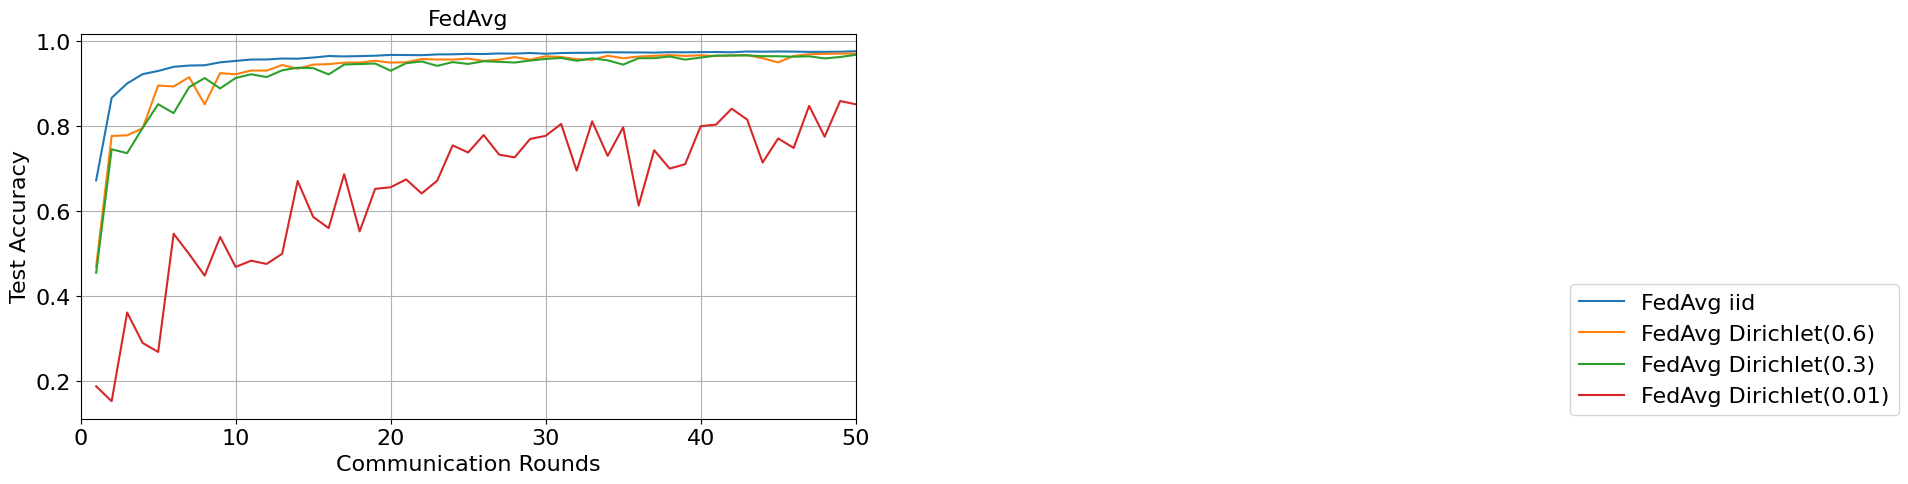

In [83]:

plt.figure(figsize=(10, 5))

for item in fedavg_test_0.keys():
  if item == 'iid':
    plt.plot(np.arange(comms_round)+1, fedavg_test_0[item][:,1], label= 'FedAvg iid')
  elif item==3:
    print('ok')
  else:
    plt.plot(np.arange(comms_round)+1, fedavg_test_0[item][:,1], label= 'FedAvg Dirichlet(' +str(item) + ')')



plt.ylabel('Test Accuracy', fontsize=16)
plt.xlabel('Communication Rounds', fontsize=16)
plt.legend(fontsize=16, loc='lower right', bbox_to_anchor=(2.36, -0.02))
plt.grid()
#plt.ylim(0.87, 0.95)
plt.xlim(0, comms_round) 
#plt.xlim(15, 20)
plt.title('FedAvg', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('plot1.pdf', dpi=1000, bbox_inches='tight')
# plt.show() 

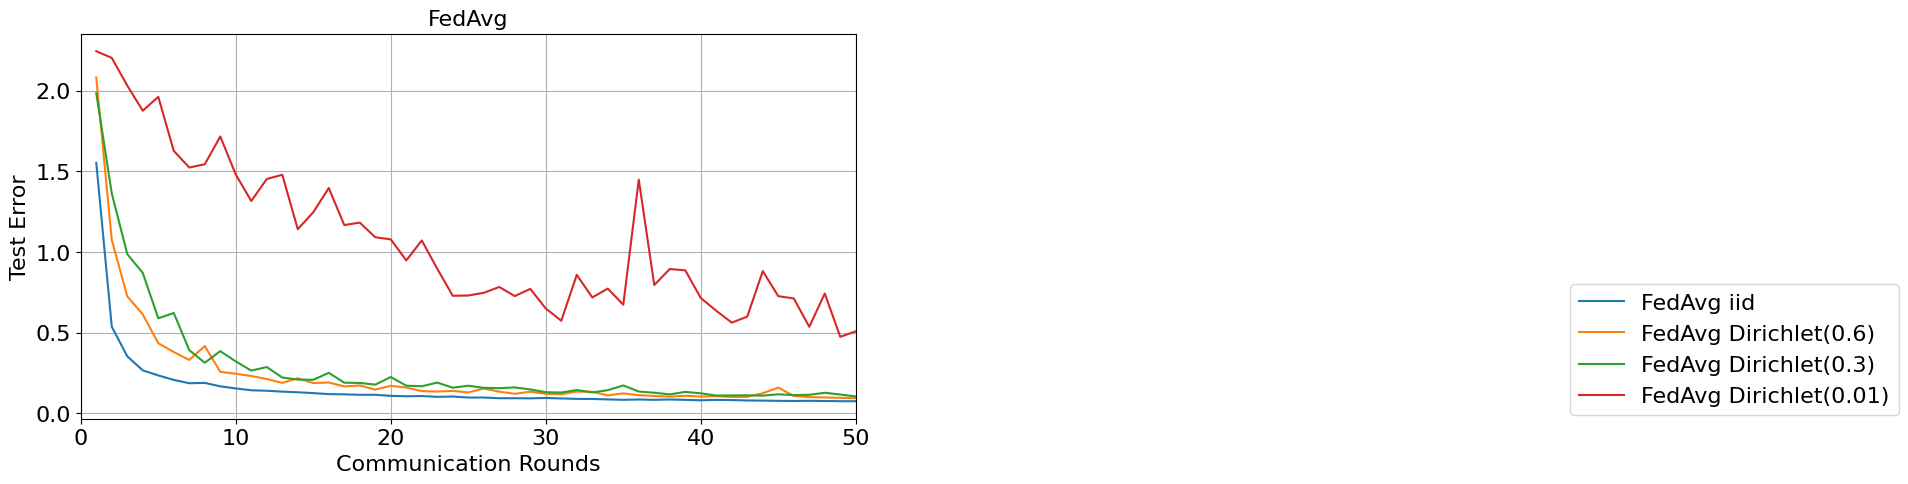

In [84]:

plt.figure(figsize=(10, 5))

for item in fedavg_test_0.keys():
  if item == 'iid':
    plt.plot(np.arange(comms_round)+1, fedavg_test_0[item][:,2], label= 'FedAvg iid')
  
  elif item==3:
    print('ok')
  else:
    plt.plot(np.arange(comms_round)+1, fedavg_test_0[item][:,2], label= 'FedAvg Dirichlet(' +str(item) + ')')



plt.ylabel('Test Error', fontsize=16)
plt.xlabel('Communication Rounds', fontsize=16)
plt.legend(fontsize=16, loc='lower right', bbox_to_anchor=(2.36, -0.02))
plt.grid()
#plt.ylim(0.87, 0.95)
plt.xlim(0, comms_round) 
#plt.xlim(15, 20)
plt.title('FedAvg', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('plot2.pdf', dpi=1000, bbox_inches='tight')
# plt.show() 

## Test 0: SCAFFOLD: acc vs err

In [14]:
B_size = 150  #Bach size
E_size = 1    # number of Epochs
comms_round = 50 # Anzahl an Iterationen

dirichlet_param = 0.3 # Der Parameter für die Dirichlet Verteilung

number_of_clients = 50 # Anzahl der Clients
active_client_ratio = 0.2 # 0.8 #ratio of active clients per iteration


learning_rate = 0.3 # Learning Rate für FedAvg
learning_rate_glob = 1.0 # globale Learning Rate für SCAFFOLD
learning_rate_loc = 0.3 # lokale Learning Rate für SCAFFOLD
alpha = 10 # Parameter für FedDyn

loss = tf.keras.losses.SparseCategoricalCrossentropy() 
metrics = ['accuracy',tf.keras.metrics.SparseCategoricalAccuracy()]
optimizer =  tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate) 

In [15]:
# TEST for non-iid data


scaffold_test_0 = dict()

list_scaffold =  ['iid', 0.6, 0.3, 0.01]


for param in list_scaffold:

  if param == 'iid':
    print('('+param +')')
    clients = create_clients_iid(x_train_sorted,y_train_sorted, num_clients=number_of_clients)
  else:
    print('('+str(param) +')')
    clients =  create_clients_non_iid(x_train_sorted,y_train_sorted, num_clients=number_of_clients, dirichlet_param=param)
  clients_batched = get_clients_batched(clients, B_size)

  #scaffold_test_0[param] = FedAvg(clients_batched,active_client_ratio, 0.5, comms_round) 
  scaffold_test_0[param] = SCAFFOLD(clients_batched,active_client_ratio, 1, 0.3, comms_round) 





(iid)
313/313 [==============================] - 1s 2ms/step
comm_round: 0 | global_acc: 68.760% | global_loss: 1.2250914573669434
313/313 [==============================] - 1s 2ms/step
comm_round: 1 | global_acc: 79.150% | global_loss: 0.7449025511741638
313/313 [==============================] - 1s 2ms/step
comm_round: 2 | global_acc: 73.360% | global_loss: 0.7873241305351257
313/313 [==============================] - 1s 2ms/step
comm_round: 3 | global_acc: 87.670% | global_loss: 0.4599173963069916
313/313 [==============================] - 1s 3ms/step
comm_round: 4 | global_acc: 88.350% | global_loss: 0.4258875846862793
313/313 [==============================] - 1s 2ms/step
comm_round: 5 | global_acc: 89.720% | global_loss: 0.36554592847824097
313/313 [==============================] - 1s 2ms/step
comm_round: 6 | global_acc: 89.600% | global_loss: 0.36429286003112793
313/313 [==============================] - 1s 2ms/step
comm_round: 7 | global_acc: 90.270% | global_loss: 0.330077111

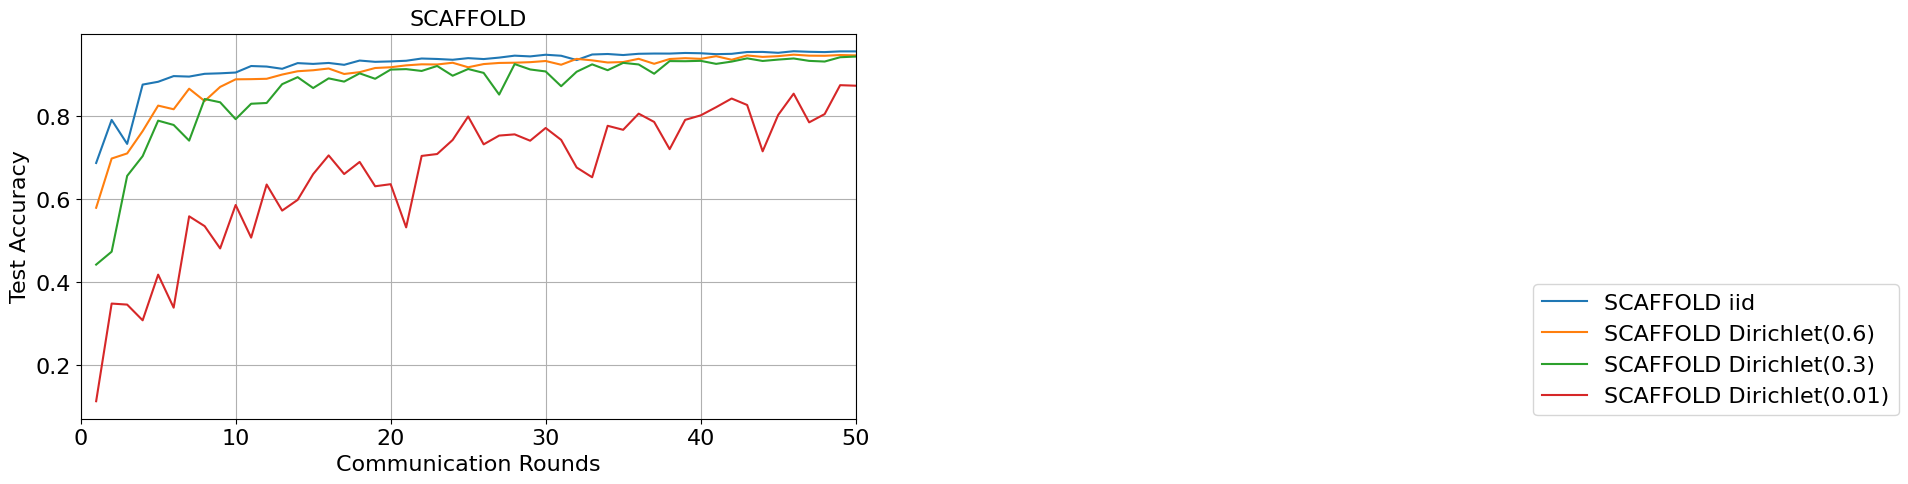

In [16]:

plt.figure(figsize=(10, 5))

for item in scaffold_test_0.keys():
  if item == 'iid':
    plt.plot(np.arange(comms_round)+1, scaffold_test_0[item][:,1], label= 'SCAFFOLD iid')
  elif item==3:
    print('ok')
  else:
    plt.plot(np.arange(comms_round)+1, scaffold_test_0[item][:,1], label= 'SCAFFOLD Dirichlet(' +str(item) + ')')



plt.ylabel('Test Accuracy', fontsize=16)
plt.xlabel('Communication Rounds', fontsize=16)
plt.legend(fontsize=16, loc='lower right', bbox_to_anchor=(2.36, -0.02))
plt.grid()
#plt.ylim(0.87, 0.95)
plt.xlim(0, comms_round) 
#plt.xlim(15, 20)
plt.title('SCAFFOLD', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('plot3.pdf', dpi=1000, bbox_inches='tight')
# plt.show() 

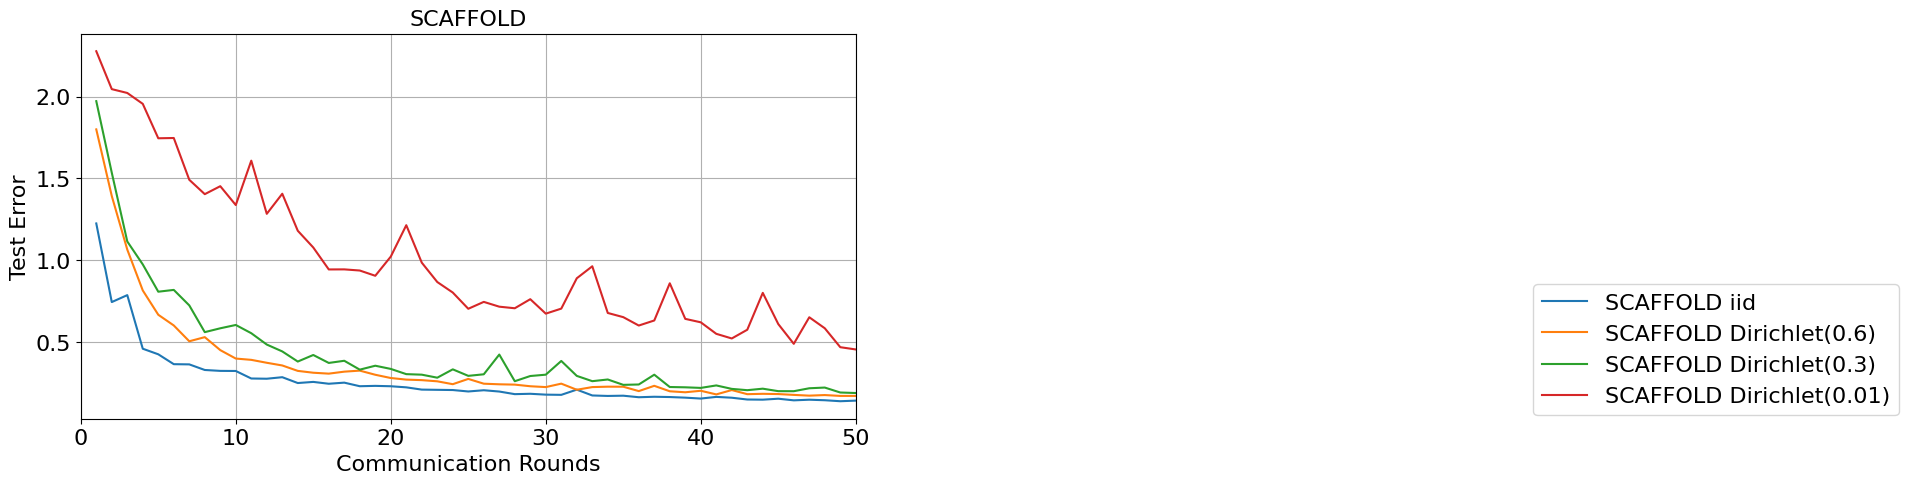

In [17]:

plt.figure(figsize=(10, 5))

for item in scaffold_test_0.keys():
  if item == 'iid':
    plt.plot(np.arange(comms_round)+1, scaffold_test_0[item][:,2], label= 'SCAFFOLD iid')
  elif item==3:
    print('ok')
  else:
    plt.plot(np.arange(comms_round)+1, scaffold_test_0[item][:,2], label= 'SCAFFOLD Dirichlet(' +str(item) + ')')



plt.ylabel('Test Error', fontsize=16)
plt.xlabel('Communication Rounds', fontsize=16)
plt.legend(fontsize=16, loc='lower right', bbox_to_anchor=(2.36, -0.02))
plt.grid()
#plt.ylim(0.87, 0.95)
plt.xlim(0, comms_round) 
#plt.xlim(15, 20)
plt.title('SCAFFOLD', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('plot4.pdf', dpi=1000, bbox_inches='tight')
# plt.show() 

## Test 1: Learning Rate FedAvg

In [ ]:
# TEST for iid data
test='iid'

fedavg_test1 = dict()
list_fedavg = [0.1, 0.3, 0.5, 0.75, 1]


clients = create_clients_iid(x_train_sorted,y_train_sorted, num_clients=number_of_clients)
clients_batched = get_clients_batched(clients, B_size)


for param in list_fedavg:
  print('('+str(param) +')')
  fedavg_test1[param] = FedAvg(clients_batched,active_client_ratio, param, comms_round) 


(0.1)
313/313 [==============================] - 1s 2ms/step
comm_round: 0 | global_acc: 45.120% | global_loss: 2.0439722537994385
313/313 [==============================] - 1s 2ms/step
comm_round: 1 | global_acc: 65.420% | global_loss: 1.7741411924362183
313/313 [==============================] - 1s 2ms/step
comm_round: 2 | global_acc: 72.610% | global_loss: 1.4751009941101074
313/313 [==============================] - 1s 3ms/step
comm_round: 3 | global_acc: 77.080% | global_loss: 1.1979221105575562
313/313 [==============================] - 1s 2ms/step
comm_round: 4 | global_acc: 79.730% | global_loss: 0.9901105761528015
313/313 [==============================] - 1s 2ms/step
comm_round: 5 | global_acc: 82.310% | global_loss: 0.8412553668022156
313/313 [==============================] - 1s 2ms/step
comm_round: 6 | global_acc: 83.170% | global_loss: 0.7346271276473999
313/313 [==============================] - 1s 2ms/step
comm_round: 7 | global_acc: 84.710% | global_loss: 0.66102617979

In [ ]:
# TEST for non-iid data
test='non-iid'

fedavg_test1 = dict()
list_fedavg =  [0.1, 0.3, 0.5, 0.75, 1]


clients =  create_clients_non_iid(x_train_sorted,y_train_sorted, num_clients=number_of_clients, dirichlet_param=dirichlet_param)
clients_batched = get_clients_batched(clients, B_size)


for param in list_fedavg:
  print('('+str(param) +')')
  fedavg_test1[param] = FedAvg(clients_batched,active_client_ratio, param, comms_round) 


(0.1)
313/313 [==============================] - 1s 2ms/step
comm_round: 0 | global_acc: 25.160% | global_loss: 2.2233872413635254
313/313 [==============================] - 1s 2ms/step
comm_round: 1 | global_acc: 28.110% | global_loss: 2.0199644565582275
313/313 [==============================] - 1s 2ms/step
comm_round: 2 | global_acc: 52.110% | global_loss: 1.8110800981521606
313/313 [==============================] - 1s 2ms/step
comm_round: 3 | global_acc: 56.420% | global_loss: 1.6090569496154785
313/313 [==============================] - 1s 2ms/step
comm_round: 4 | global_acc: 59.000% | global_loss: 1.4500949382781982
313/313 [==============================] - 1s 2ms/step
comm_round: 5 | global_acc: 73.630% | global_loss: 1.2439203262329102
313/313 [==============================] - 1s 2ms/step
comm_round: 6 | global_acc: 68.940% | global_loss: 1.1815440654754639
313/313 [==============================] - 1s 2ms/step
comm_round: 7 | global_acc: 76.040% | global_loss: 1.03233909606

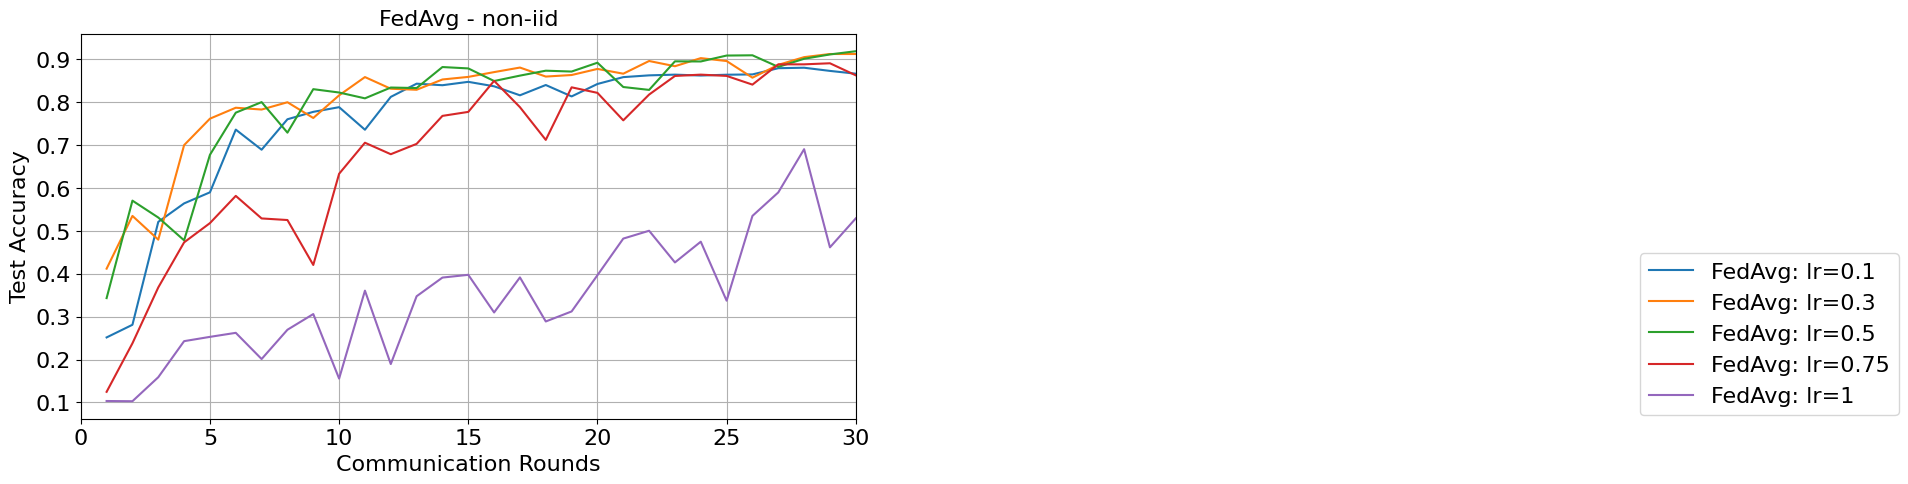

In [ ]:

plt.figure(figsize=(10, 5))

for item in fedavg_test1.keys():
  plt.plot(np.arange(comms_round)+1, fedavg_test1[item][:,1], label='FedAvg: lr='+ str(item))



plt.ylabel('Test Accuracy', fontsize=16)
plt.xlabel('Communication Rounds', fontsize=16)
plt.legend(fontsize=16, loc='lower right', bbox_to_anchor=(2.36, -0.02))
plt.grid()
#plt.ylim(0.87, 0.95)
plt.xlim(0, comms_round) 
#plt.xlim(15, 20)
plt.title('FedAvg - '+test, fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('plot.pdf', dpi=1000, bbox_inches='tight')
# plt.show() 

## Test 1: Learning Rate SCAFFOLD

In [ ]:
# TEST for iid data
test='iid'

scaffold_test1 = dict()
list_scaffold_l = [0.1,0.3, 0.5, 0.75, 1] 
list_scaffold_g = [1.0] #[0.1,0.3,0.5, 0.75,1]  

clients = create_clients_iid(x_train_sorted,y_train_sorted, num_clients=number_of_clients)
clients_batched = get_clients_batched(clients, B_size)

for param1 in list_scaffold_g:
  for param2 in list_scaffold_l:
    print('('+str(param1) +", "+ str(param2) +')')
    scaffold_test1['('+str(param1) +", "+ str(param2) +')'] = SCAFFOLD(clients_batched,active_client_ratio, param1, param2, comms_round) 


(1.0, 0.1)
313/313 [==============================] - 1s 3ms/step
comm_round: 0 | global_acc: 43.570% | global_loss: 2.059627056121826
313/313 [==============================] - 1s 3ms/step
comm_round: 1 | global_acc: 62.100% | global_loss: 1.778602957725525
313/313 [==============================] - 1s 2ms/step
comm_round: 2 | global_acc: 74.920% | global_loss: 1.462595820426941
313/313 [==============================] - 1s 2ms/step
comm_round: 3 | global_acc: 78.390% | global_loss: 1.1798481941223145
313/313 [==============================] - 1s 2ms/step
comm_round: 4 | global_acc: 82.020% | global_loss: 0.9673056602478027
313/313 [==============================] - 1s 2ms/step
comm_round: 5 | global_acc: 83.060% | global_loss: 0.818110466003418
313/313 [==============================] - 1s 2ms/step
comm_round: 6 | global_acc: 84.550% | global_loss: 0.7143875956535339
313/313 [==============================] - 1s 2ms/step
comm_round: 7 | global_acc: 85.210% | global_loss: 0.6453284621

In [ ]:
# TEST for non-iid data
test='non-iid'

scaffold_test1 = dict()
list_scaffold_l = [0.1,0.3, 0.5, 0.75, 1] #[0.1,0.3, 0.5, 0.75, 1] #[0.35] #[0.05,0.2,0.35, 0.5, 0.65, 0.8, 0.95]
list_scaffold_g = [1.0] #[0.1,0.3,0.5, 0.75,1]  

clients =  create_clients_non_iid(x_train_sorted,y_train_sorted, num_clients=number_of_clients, dirichlet_param=dirichlet_param)
clients_batched = get_clients_batched(clients, B_size)

for param1 in list_scaffold_g:
  for param2 in list_scaffold_l:
    print('('+str(param1) +", "+ str(param2) +')')
    scaffold_test1['('+str(param1) +", "+ str(param2) +')'] = SCAFFOLD(clients_batched,active_client_ratio, param1, param2, comms_round) 


(1.0, 0.1)
313/313 [==============================] - 1s 2ms/step
comm_round: 0 | global_acc: 28.130% | global_loss: 2.1413283348083496
313/313 [==============================] - 1s 2ms/step
comm_round: 1 | global_acc: 47.830% | global_loss: 1.9701383113861084
313/313 [==============================] - 1s 2ms/step
comm_round: 2 | global_acc: 50.900% | global_loss: 1.7745250463485718
313/313 [==============================] - 1s 2ms/step
comm_round: 3 | global_acc: 61.570% | global_loss: 1.5569055080413818
313/313 [==============================] - 1s 2ms/step
comm_round: 4 | global_acc: 71.590% | global_loss: 1.3718552589416504
313/313 [==============================] - 1s 2ms/step
comm_round: 5 | global_acc: 66.750% | global_loss: 1.2534410953521729
313/313 [==============================] - 1s 2ms/step
comm_round: 6 | global_acc: 67.680% | global_loss: 1.1317358016967773
313/313 [==============================] - 1s 2ms/step
comm_round: 7 | global_acc: 70.700% | global_loss: 1.063464

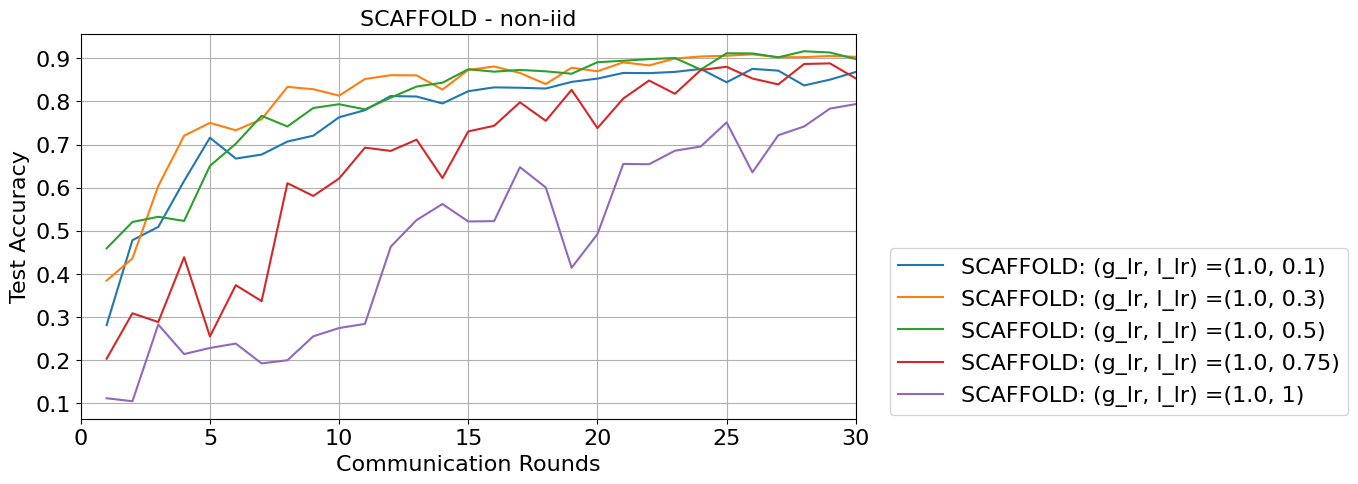

In [ ]:

plt.figure(figsize=(10, 5))

for item in scaffold_test1.keys():
  plt.plot(np.arange(comms_round)+1, scaffold_test1[item][:,1], label='SCAFFOLD: (g_lr, l_lr) ='+ str(item) )

plt.ylabel('Test Accuracy', fontsize=16)
plt.xlabel('Communication Rounds', fontsize=16)
plt.legend(fontsize=16, loc='lower right', bbox_to_anchor=(1.65, -0.02))
plt.grid()
#plt.ylim(0.59, 0.83)
plt.xlim(0, comms_round) 
#plt.xlim(15, 20)
plt.title('SCAFFOLD - '+test, fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('plot.pdf', dpi=1000, bbox_inches='tight')
# plt.show() 

## Test 2: Batch Size FedAvg

In [ ]:
# TEST for iid data
test='iid'

fedavg_test2 = dict()
list_fedavg =  [10, 50, 100, 500 , 1000]  

clients = create_clients_iid(x_train_sorted,y_train_sorted, num_clients=number_of_clients)


for param in list_fedavg:
    print('('+str(param) +')')
    clients_batched = get_clients_batched(clients, param)
    fedavg_test2[param] = FedAvg(clients_batched,active_client_ratio,learning_rate, comms_round) 


(10)
313/313 [==============================] - 1s 2ms/step
comm_round: 0 | global_acc: 84.980% | global_loss: 0.8962023258209229
313/313 [==============================] - 1s 2ms/step
comm_round: 1 | global_acc: 90.840% | global_loss: 0.3776300847530365
313/313 [==============================] - 1s 2ms/step
comm_round: 2 | global_acc: 92.500% | global_loss: 0.28288090229034424
313/313 [==============================] - 1s 2ms/step
comm_round: 3 | global_acc: 93.520% | global_loss: 0.23385478556156158
313/313 [==============================] - 1s 2ms/step
comm_round: 4 | global_acc: 94.110% | global_loss: 0.2089730054140091
313/313 [==============================] - 1s 2ms/step
comm_round: 5 | global_acc: 94.610% | global_loss: 0.1894346922636032
313/313 [==============================] - 1s 2ms/step
comm_round: 6 | global_acc: 94.920% | global_loss: 0.1736150085926056
313/313 [==============================] - 1s 2ms/step
comm_round: 7 | global_acc: 95.550% | global_loss: 0.1555539965

In [ ]:
# TEST for non-iid data
test='non-iid'

fedavg_test2 = dict()
list_fedavg =  [10, 50, 100, 500 , 1000]  


clients =  create_clients_non_iid(x_train_sorted,y_train_sorted, num_clients=number_of_clients, dirichlet_param=dirichlet_param)

for param in list_fedavg:
    print('('+str(param) +')')
    clients_batched = get_clients_batched(clients, param)
    fedavg_test2[param] = FedAvg(clients_batched,active_client_ratio,learning_rate, comms_round) 


(10)
313/313 [==============================] - 1s 2ms/step
comm_round: 0 | global_acc: 54.920% | global_loss: 1.8900556564331055
313/313 [==============================] - 1s 2ms/step
comm_round: 1 | global_acc: 80.230% | global_loss: 0.8551599383354187
313/313 [==============================] - 1s 2ms/step
comm_round: 2 | global_acc: 80.120% | global_loss: 0.7387069463729858
313/313 [==============================] - 1s 2ms/step
comm_round: 3 | global_acc: 85.300% | global_loss: 0.5017768740653992
313/313 [==============================] - 1s 2ms/step
comm_round: 4 | global_acc: 88.750% | global_loss: 0.39749497175216675
313/313 [==============================] - 1s 2ms/step
comm_round: 5 | global_acc: 91.770% | global_loss: 0.2960754930973053
313/313 [==============================] - 1s 2ms/step
comm_round: 6 | global_acc: 92.690% | global_loss: 0.28307807445526123
313/313 [==============================] - 1s 2ms/step
comm_round: 7 | global_acc: 92.180% | global_loss: 0.2757211029

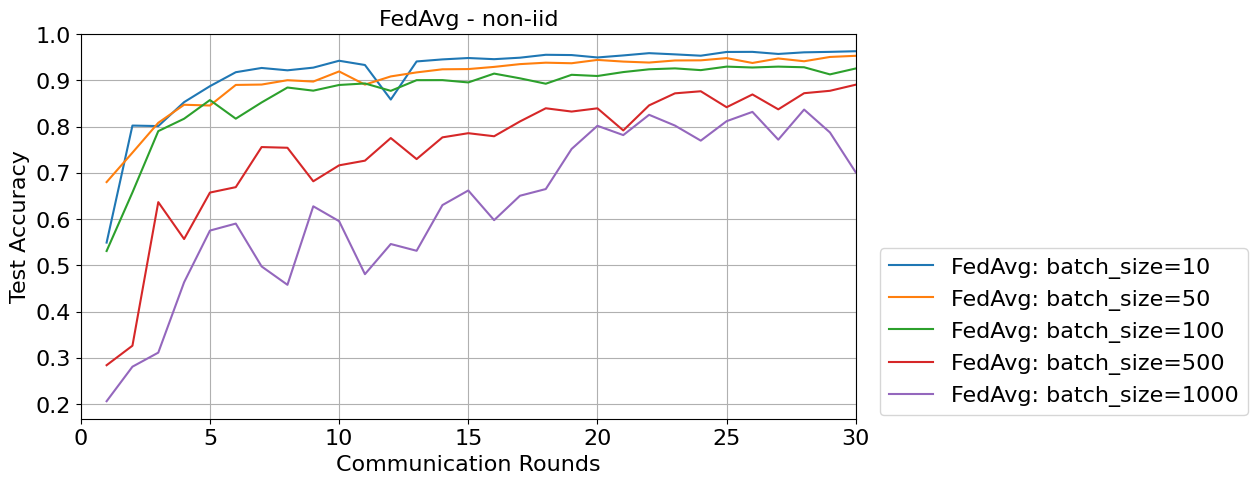

In [ ]:

plt.figure(figsize=(10, 5))


for item in fedavg_test2.keys():
  plt.plot(np.arange(comms_round)+1, fedavg_test2[item][:,1], label='FedAvg: batch_size='+ str(item))
  #plt.plot(fedavg_test2[item][:,0], fedavg_test2[item][:,1], label='FedAvg: batch_size='+ str(item))
plt.ylabel('Test Accuracy', fontsize=16)
plt.xlabel('Communication Rounds', fontsize=16)
plt.legend(fontsize=16, loc='lower right', bbox_to_anchor=(1.52, -0.02))
plt.grid()
#plt.ylim(0.87, 0.95)
plt.xlim(0, comms_round) 
#plt.xlim(15, 20)
plt.title('FedAvg - '+test, fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('plot.pdf', dpi=1000, bbox_inches='tight')
# plt.show() 

## Test 2: Batch Size SCAFFOLD

In [56]:
# TEST for iid data
test='iid'

scaffold_test2 = dict()
list_scaffold = [10, 50, 100, 500 , 1000]  

clients = create_clients_iid(x_train_sorted,y_train_sorted, num_clients=number_of_clients)


for param in list_scaffold:
    print('('+str(param) +')')
    clients_batched = get_clients_batched(clients, param)
    scaffold_test2[str(param) ] = SCAFFOLD(clients_batched,active_client_ratio, learning_rate_glob, learning_rate_loc, comms_round) 


(10)
313/313 [==============================] - 1s 2ms/step
comm_round: 0 | global_acc: 84.890% | global_loss: 0.9196751713752747
313/313 [==============================] - 1s 2ms/step
comm_round: 1 | global_acc: 90.490% | global_loss: 0.38243910670280457
313/313 [==============================] - 1s 2ms/step
comm_round: 2 | global_acc: 92.180% | global_loss: 0.294002503156662
313/313 [==============================] - 1s 2ms/step
comm_round: 3 | global_acc: 93.320% | global_loss: 0.2398538589477539
313/313 [==============================] - 1s 2ms/step
comm_round: 4 | global_acc: 93.740% | global_loss: 0.2158624529838562
313/313 [==============================] - 1s 2ms/step
comm_round: 5 | global_acc: 94.710% | global_loss: 0.18134480714797974
313/313 [==============================] - 1s 2ms/step
comm_round: 6 | global_acc: 95.110% | global_loss: 0.16355125606060028
313/313 [==============================] - 1s 2ms/step
comm_round: 7 | global_acc: 95.400% | global_loss: 0.1573136001

In [ ]:
# TEST for non-iid data
test='non-iid'

scaffold_test2 = dict()
list_scaffold = [10, 50, 100, 500 , 1000]  

clients =  create_clients_non_iid(x_train_sorted,y_train_sorted, num_clients=number_of_clients, dirichlet_param=dirichlet_param)

for param in list_scaffold:
    print('('+str(param) +')')
    clients_batched = get_clients_batched(clients, param)
    scaffold_test2[str(param) ] = SCAFFOLD(clients_batched,active_client_ratio, learning_rate_glob, learning_rate_loc, comms_round) 


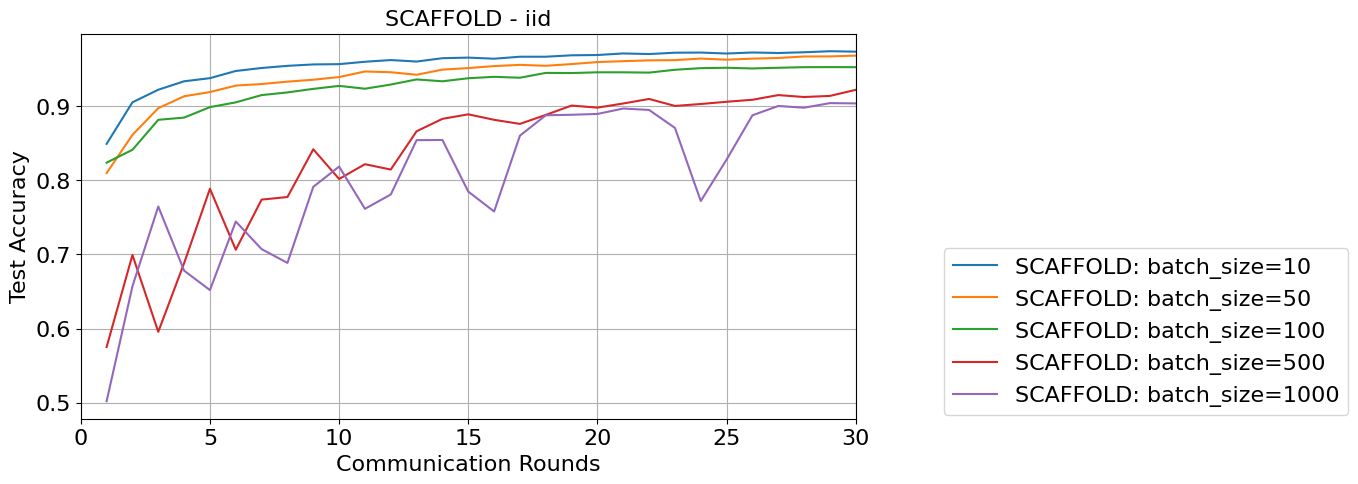

In [67]:
plt.figure(figsize=(10, 5))

for item in scaffold_test2.keys():
  plt.plot(np.arange(comms_round)+1, scaffold_test2[item][:,1], label='SCAFFOLD: batch_size='+ str(item) )

plt.ylabel('Test Accuracy', fontsize=16)
plt.xlabel('Communication Rounds', fontsize=16)
plt.legend(fontsize=16, loc='lower right', bbox_to_anchor=(1.65, -0.02))
plt.grid()
#plt.ylim(0.8, 0.93)
plt.xlim(0, comms_round) 
#plt.xlim(15, 20)
plt.title('SCAFFOLD - '+test, fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('plot.pdf', dpi=1000, bbox_inches='tight')
# plt.show() 

## Test 3: Epoch Size FedAvg

In [68]:
# TEST for iid data
test='iid'

fedavg_test3 = dict()
list_fedavg = [1, 2, 3]  

clients = create_clients_iid(x_train_sorted,y_train_sorted, num_clients=number_of_clients)
clients_batched = get_clients_batched(clients, B_size)

for param in list_fedavg:
    print('('+str(param) +')')
    E_size = param
    fedavg_test3[param] = FedAvg(clients_batched,active_client_ratio, learning_rate, comms_round, param) 


(1)
313/313 [==============================] - 1s 2ms/step
comm_round: 0 | global_acc: 70.310% | global_loss: 1.5076440572738647
313/313 [==============================] - 1s 2ms/step
comm_round: 1 | global_acc: 73.050% | global_loss: 1.0110070705413818
313/313 [==============================] - 1s 2ms/step
comm_round: 2 | global_acc: 75.140% | global_loss: 0.8102126717567444
313/313 [==============================] - 1s 2ms/step
comm_round: 3 | global_acc: 79.400% | global_loss: 0.6932966709136963
313/313 [==============================] - 1s 2ms/step
comm_round: 4 | global_acc: 86.610% | global_loss: 0.5175477266311646
313/313 [==============================] - 1s 2ms/step
comm_round: 5 | global_acc: 84.600% | global_loss: 0.5181937217712402
313/313 [==============================] - 1s 2ms/step
comm_round: 6 | global_acc: 85.180% | global_loss: 0.46737149357795715
313/313 [==============================] - 1s 2ms/step
comm_round: 7 | global_acc: 87.000% | global_loss: 0.457183003425

In [69]:
# TEST for non-iid data
test='non-iid'

fedavg_test3 = dict()
list_fedavg = [1, 2, 3]  

clients =  create_clients_non_iid(x_train_sorted,y_train_sorted, num_clients=number_of_clients, dirichlet_param=dirichlet_param)
clients_batched = get_clients_batched(clients, B_size)

for param in list_fedavg:
    print('('+str(param) +')')
    fedavg_test3[param] = FedAvg(clients_batched,active_client_ratio, learning_rate, comms_round,param) 


(1)
313/313 [==============================] - 1s 2ms/step
comm_round: 0 | global_acc: 27.430% | global_loss: 2.112922191619873
313/313 [==============================] - 1s 2ms/step
comm_round: 1 | global_acc: 66.020% | global_loss: 1.7647545337677002
313/313 [==============================] - 1s 2ms/step
comm_round: 2 | global_acc: 61.870% | global_loss: 1.575033187866211
313/313 [==============================] - 1s 2ms/step
comm_round: 3 | global_acc: 63.990% | global_loss: 1.3073853254318237
313/313 [==============================] - 1s 2ms/step
comm_round: 4 | global_acc: 71.430% | global_loss: 1.1371504068374634
313/313 [==============================] - 1s 2ms/step
comm_round: 5 | global_acc: 72.640% | global_loss: 1.0880043506622314
313/313 [==============================] - 1s 2ms/step
comm_round: 6 | global_acc: 76.690% | global_loss: 0.8538674116134644
313/313 [==============================] - 1s 2ms/step
comm_round: 7 | global_acc: 76.130% | global_loss: 0.852758228778839

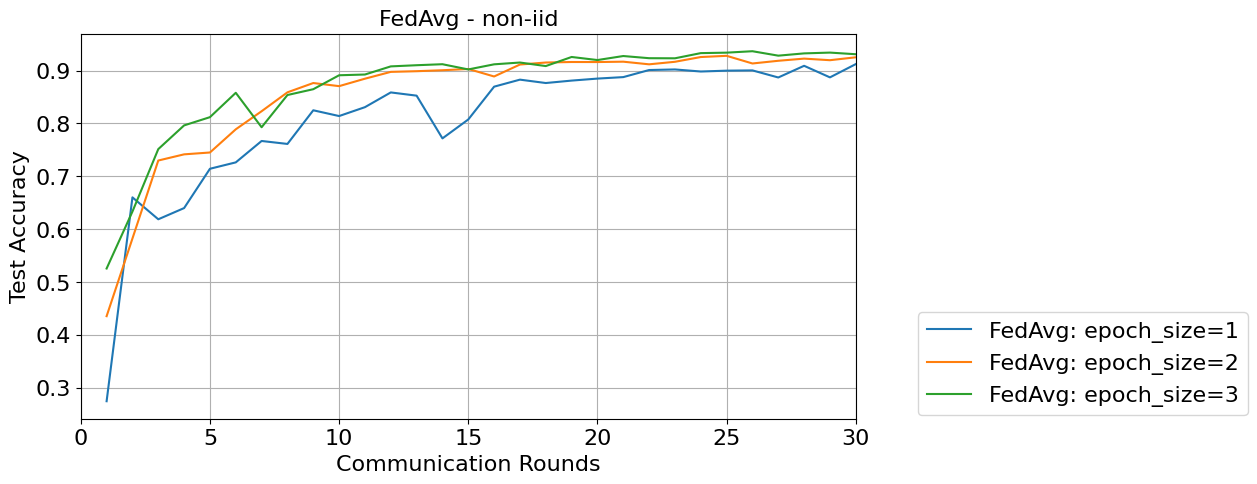

In [70]:

plt.figure(figsize=(10, 5))

for item in fedavg_test3.keys():
  plt.plot(np.arange(comms_round)+1, fedavg_test3[item][:,1], label='FedAvg: epoch_size='+ str(item) )
  #plt.plot(fedavg_test3[item][:,0], fedavg_test3[item][:,1], label='FedAvg: epoch_size='+ str(item) )

plt.ylabel('Test Accuracy', fontsize=16)
plt.xlabel('Communication Rounds', fontsize=16)
plt.legend(fontsize=16, loc='lower right', bbox_to_anchor=(1.52, -0.02))
plt.grid()
#plt.ylim(0.87, 0.95)
plt.xlim(0, comms_round) 
#plt.xlim(15, 20)
plt.title('FedAvg - '+test, fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('plot.pdf', dpi=1000, bbox_inches='tight')
# plt.show() 

## Test 4: Epoch Size SCAFFOLD

In [71]:
# TEST for iid data
test='iid'

scaffold_test3 = dict()
list_scaffold = [1, 2, 3]  

clients = create_clients_iid(x_train_sorted,y_train_sorted, num_clients=number_of_clients)
clients_batched = get_clients_batched(clients, B_size)

for param in list_scaffold:
    print('('+str(param) +')')
    scaffold_test3[str(param) ] = SCAFFOLD(clients_batched,active_client_ratio, learning_rate_glob, learning_rate_loc, comms_round,param) 


(1)
313/313 [==============================] - 1s 2ms/step
comm_round: 0 | global_acc: 65.760% | global_loss: 1.6761538982391357
313/313 [==============================] - 1s 2ms/step
comm_round: 1 | global_acc: 74.820% | global_loss: 1.0377755165100098
313/313 [==============================] - 1s 2ms/step
comm_round: 2 | global_acc: 82.190% | global_loss: 0.7565457820892334
313/313 [==============================] - 1s 2ms/step
comm_round: 3 | global_acc: 82.770% | global_loss: 0.629127562046051
313/313 [==============================] - 1s 2ms/step
comm_round: 4 | global_acc: 81.600% | global_loss: 0.6227951049804688
313/313 [==============================] - 1s 2ms/step
comm_round: 5 | global_acc: 86.210% | global_loss: 0.48457154631614685
313/313 [==============================] - 1s 2ms/step
comm_round: 6 | global_acc: 85.670% | global_loss: 0.46290937066078186
313/313 [==============================] - 1s 2ms/step
comm_round: 7 | global_acc: 88.860% | global_loss: 0.402981877326

In [72]:
# TEST for non-iid data
test='non-iid'

scaffold_test3 = dict()
list_scaffold = [1, 2, 3]  

clients =  create_clients_non_iid(x_train_sorted,y_train_sorted, num_clients=number_of_clients, dirichlet_param=dirichlet_param)
clients_batched = get_clients_batched(clients, B_size)

for param in list_scaffold:
    print('('+str(param) +')')
    E_size = param
    scaffold_test3[str(param) ] = SCAFFOLD(clients_batched,active_client_ratio, learning_rate_glob, learning_rate_loc, comms_round, param) 


(1)
313/313 [==============================] - 1s 2ms/step
comm_round: 0 | global_acc: 33.590% | global_loss: 2.013012409210205
313/313 [==============================] - 1s 2ms/step
comm_round: 1 | global_acc: 57.730% | global_loss: 1.629151463508606
313/313 [==============================] - 1s 2ms/step
comm_round: 2 | global_acc: 60.110% | global_loss: 1.5215792655944824
313/313 [==============================] - 1s 2ms/step
comm_round: 3 | global_acc: 69.020% | global_loss: 1.1381109952926636
313/313 [==============================] - 1s 2ms/step
comm_round: 4 | global_acc: 76.810% | global_loss: 1.1179568767547607
313/313 [==============================] - 1s 2ms/step
comm_round: 5 | global_acc: 78.410% | global_loss: 0.9372515678405762
313/313 [==============================] - 1s 2ms/step
comm_round: 6 | global_acc: 80.120% | global_loss: 0.8567094802856445
313/313 [==============================] - 1s 2ms/step
comm_round: 7 | global_acc: 79.900% | global_loss: 0.740155279636383

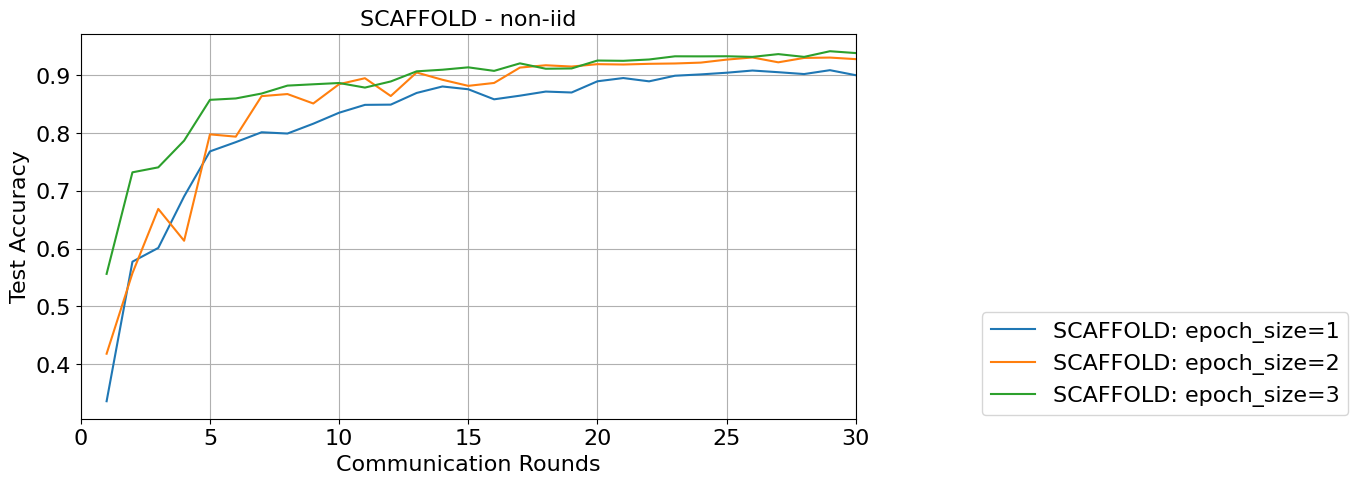

In [73]:
plt.figure(figsize=(10, 5))


for item in scaffold_test3.keys():
  plt.plot(np.arange(comms_round)+1, scaffold_test3[item][:,1], label='SCAFFOLD: epoch_size='+ str(item) )
  #plt.plot(scaffold_test3[item][:,0], scaffold_test3[item][:,1], label='SCAFFOLD: epoch_size='+ str(item) )

plt.ylabel('Test Accuracy', fontsize=16)
plt.xlabel('Communication Rounds', fontsize=16)
plt.legend(fontsize=16, loc='lower right', bbox_to_anchor=(1.65, -0.02))
plt.grid()
#plt.ylim(0.8, 0.93)
plt.xlim(0, comms_round) 
#plt.xlim(15, 20)
plt.title('SCAFFOLD - '+test, fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('plot.pdf', dpi=1000, bbox_inches='tight')
# plt.show() 

## Test 5: Client Size FedAvg

In [ ]:
# TEST for iid data
test='iid'

fedavg_test4 = dict()
list_fedavg = [10, 25, 50, 100, 200]  

for param in list_fedavg:
    print('('+str(param) +')')
    clients = create_clients_iid(x_train_sorted,y_train_sorted, num_clients=param)
    clients_batched = get_clients_batched(clients, B_size)
    fedavg_test4[param] = FedAvg(clients_batched,active_client_ratio,learning_rate, comms_round) 


In [ ]:
# TEST for non-iid data
test='non-iid'

fedavg_test4 = dict()
list_fedavg = [10, 25, 50, 100, 200]  

for param in list_fedavg:
    print('('+str(param) +')')

    clients =  create_clients_non_iid(x_train_sorted,y_train_sorted, num_clients=param,  dirichlet_param=dirichlet_param)
    clients_batched = get_clients_batched(clients, B_size)
    fedavg_test4[param] = FedAvg(clients_batched,active_client_ratio, learning_rate, comms_round) 


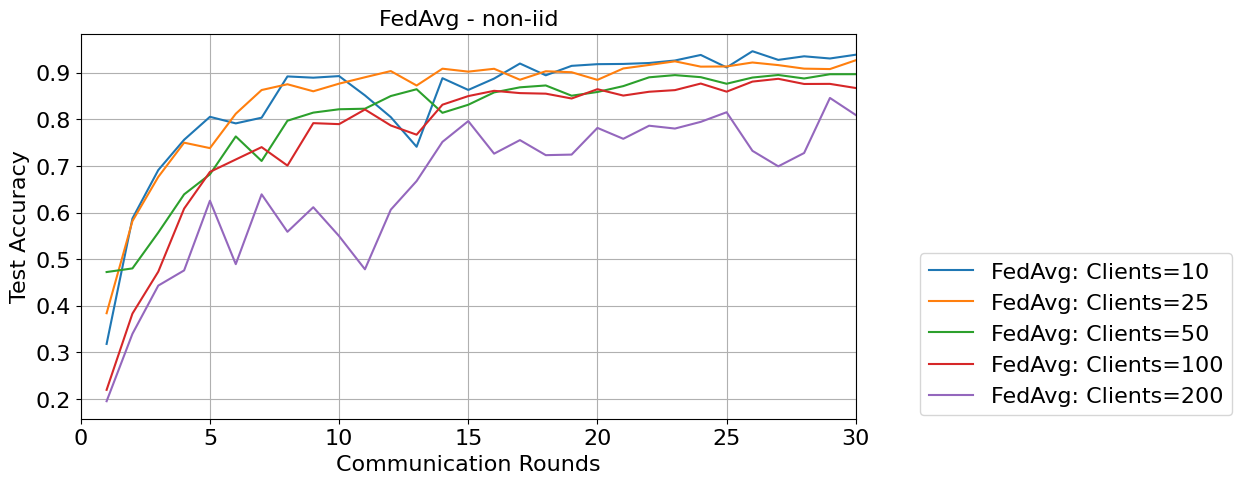

In [ ]:

plt.figure(figsize=(10, 5))


for item in fedavg_test4.keys():
  plt.plot(np.arange(comms_round)+1, fedavg_test4[item][:,1], label='FedAvg: Clients='+ str(item) )


plt.ylabel('Test Accuracy', fontsize=16)
plt.xlabel('Communication Rounds', fontsize=16)
plt.legend(fontsize=16, loc='lower right', bbox_to_anchor=(1.5, -0.02))
plt.grid()
#plt.ylim(0.87, 0.95)
plt.xlim(0, comms_round) 
#plt.xlim(15, 20)
plt.title('FedAvg - '+test, fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('plot.pdf', dpi=1000, bbox_inches='tight')
# plt.show() 

## Test 5: Client Size SCAFFOLD

In [74]:
# TEST for iid data
test='iid'


scaffold_test4 = dict()
list_scaffold = [10, 25, 50, 100, 200]  

for param in list_scaffold:
    print('('+str(param) +')')
    clients = create_clients_iid(x_train_sorted,y_train_sorted, num_clients=param)
    clients_batched = get_clients_batched(clients, B_size)
    scaffold_test4[str(param) ] = SCAFFOLD(clients_batched,active_client_ratio, learning_rate_glob, learning_rate_loc, comms_round) 


(10)
313/313 [==============================] - 1s 2ms/step
comm_round: 0 | global_acc: 81.850% | global_loss: 0.6379922032356262
313/313 [==============================] - 1s 2ms/step
comm_round: 1 | global_acc: 88.990% | global_loss: 0.3958355784416199
313/313 [==============================] - 1s 2ms/step
comm_round: 2 | global_acc: 90.080% | global_loss: 0.3385390043258667
313/313 [==============================] - 1s 2ms/step
comm_round: 3 | global_acc: 91.850% | global_loss: 0.28412264585494995
313/313 [==============================] - 1s 2ms/step
comm_round: 4 | global_acc: 91.890% | global_loss: 0.2727377712726593
313/313 [==============================] - 1s 2ms/step
comm_round: 5 | global_acc: 92.350% | global_loss: 0.25656458735466003
313/313 [==============================] - 1s 2ms/step
comm_round: 6 | global_acc: 93.400% | global_loss: 0.23043139278888702
313/313 [==============================] - 1s 2ms/step
comm_round: 7 | global_acc: 93.600% | global_loss: 0.218811348

In [75]:
# TEST for non-iid data
test='non-iid'


scaffold_test4 = dict()
list_scaffold = [10, 25, 50, 100, 200]  

for param in list_scaffold:
    print('('+str(param) +')')
    clients =  create_clients_non_iid(x_train_sorted,y_train_sorted, num_clients=param, dirichlet_param=dirichlet_param)
    clients_batched = get_clients_batched(clients, B_size)
    scaffold_test4[str(param) ] = SCAFFOLD(clients_batched,active_client_ratio, learning_rate_glob, learning_rate_loc, comms_round) 


(10)
313/313 [==============================] - 1s 2ms/step
comm_round: 0 | global_acc: 53.500% | global_loss: 1.6786671876907349
313/313 [==============================] - 1s 2ms/step
comm_round: 1 | global_acc: 43.530% | global_loss: 1.6287833452224731
313/313 [==============================] - 1s 2ms/step
comm_round: 2 | global_acc: 73.800% | global_loss: 1.037519931793213
313/313 [==============================] - 1s 2ms/step
comm_round: 3 | global_acc: 84.270% | global_loss: 0.5575659275054932
313/313 [==============================] - 1s 2ms/step
comm_round: 4 | global_acc: 75.180% | global_loss: 0.6935688257217407
313/313 [==============================] - 1s 2ms/step
comm_round: 5 | global_acc: 85.570% | global_loss: 0.45962080359458923
313/313 [==============================] - 1s 2ms/step
comm_round: 6 | global_acc: 82.270% | global_loss: 0.5379514098167419
313/313 [==============================] - 1s 2ms/step
comm_round: 7 | global_acc: 88.360% | global_loss: 0.383850485086

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(10, 5))


for item in scaffold_test4.keys():
  plt.plot(np.arange(comms_round)+1, scaffold_test4[item][:,1], label='SCAFFOLD: Clients='+ str(item) )

plt.ylabel('Test Accuracy', fontsize=16)
plt.xlabel('Communication Rounds', fontsize=16)
plt.legend(fontsize=16, loc='lower right', bbox_to_anchor=(1.48, -0.02))
plt.grid()
#plt.ylim(0.8, 0.93)
plt.xlim(0, comms_round) 
#plt.xlim(15, 20)
plt.title('SCAFFOLD - '+test, fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('plot.pdf', dpi=1000, bbox_inches='tight')
# plt.show() 

## Test 6: Active Client Size FedAvg

In [ ]:
# TEST for iid data
test='iid'

number_of_clients2 = 100

fedavg_test5 = dict()
list_fedavg = [1, 5, 25, 50, 100]  

clients = create_clients_iid(x_train_sorted,y_train_sorted, num_clients=number_of_clients2 )

for param in list_fedavg:
    print('('+str(param) +')')
    
    clients_batched = get_clients_batched(clients, B_size)
    fedavg_test5[param] = FedAvg(clients_batched,param/100,learning_rate, comms_round) 


In [ ]:
# TEST for non-iid data
test='non-iid'

number_of_clients2 = 100

fedavg_test5 = dict()
list_fedavg = [1, 5, 25, 50, 100]  

clients =  create_clients_non_iid(x_train_sorted,y_train_sorted, num_clients=number_of_clients2,  dirichlet_param=dirichlet_param)

for param in list_fedavg:
    print('('+str(param) +')')
    
    clients_batched = get_clients_batched(clients, B_size)
    fedavg_test5[param] = FedAvg(clients_batched,param/100, 0.3, comms_round) 


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for item in fedavg_test5.keys():
  plt.plot(np.arange(comms_round)+1, fedavg_test5[item][:,1], label='FedAvg: Aktive Clients='+ str(item)) 

plt.ylabel('Test Accuracy', fontsize=16)
plt.xlabel('Communication Rounds', fontsize=16)
plt.legend(fontsize=16, loc='lower right', bbox_to_anchor=(1.55, -0.02))
plt.grid()
#plt.ylim(0.80, 0.95)
plt.xlim(0, comms_round) 
#plt.xlim(15, 20)
plt.title('FedAvg - '+test, fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('plot.pdf', dpi=1000, bbox_inches='tight')
# plt.show() 

## Test 6: Active Client Size SCAFFOLD

In [ ]:
# TEST for iid data
test='iid'

number_of_clients2= 100

scaffold_test5  = dict()
list_scaffold = [1, 5, 25, 50, 100]  

clients = create_clients_iid(x_train_sorted,y_train_sorted, num_clients=number_of_clients2)


for param in list_scaffold:
    print('('+str(param) +')')
    
    clients_batched = get_clients_batched(clients, B_size)
    scaffold_test5[str(param) ] = SCAFFOLD(clients_batched,param/100, learning_rate_glob, learning_rate_loc, comms_round) 


In [ ]:
# TEST for non-iid data
test='non-iid'

number_of_clients2= 100

scaffold_test5 = dict()
list_scaffold = [1, 5, 25, 50, 100]  # Gebe Anzahl der aktiven Clients 

clients =  create_clients_non_iid(x_train_sorted,y_train_sorted, num_clients=number_of_clients2, dirichlet_param=dirichlet_param)

for param in list_scaffold:
    print('('+str(param) +')')
    
    clients_batched = get_clients_batched(clients, B_size)
    scaffold_test5[str(param) ] = SCAFFOLD(clients_batched,param/100, learning_rate_glob, learning_rate_loc, comms_round) 


In [ ]:
plt.figure(figsize=(10, 5))

for item in scaffold_test5.keys():
  plt.plot(np.arange(comms_round)+1, scaffold_test5[item][:,1], label='SCAFFOLD: Aktive Clients='+ item) 

plt.ylabel('Test Accuracy', fontsize=16)
plt.xlabel('Communication Rounds', fontsize=16)
plt.legend(fontsize=16, loc='lower right', bbox_to_anchor=(1.59, -0.02))
plt.grid()
#plt.ylim(0.8, 0.93)
plt.xlim(0, comms_round) 
#plt.xlim(15, 20)
plt.title('SCAFFOLD - '+test, fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('plot.pdf', dpi=1000, bbox_inches='tight')
# plt.show() 

## Test: Learning Rate FedDyn

In [ ]:
# TEST for iid data
test='iid'

feddyn_test1 = dict()
list_feddyn = [ 10, 20, 25,30, 40]


clients = create_clients_iid(x_train_sorted,y_train_sorted, num_clients=number_of_clients)
clients_batched = get_clients_unbatched(clients)


for param in list_feddyn:
  print('('+str(param) +')')
  feddyn_test1[param] = FedDyn(clients_batched,active_client_ratio, param, comms_round) 


In [ ]:
# TEST for non-iid data
test='non-iid'

feddyn_test1 = dict()
list_feddyn =  [ 10, 20, 25,30, 40]


clients =  create_clients_non_iid(x_train_sorted,y_train_sorted, num_clients=number_of_clients,  dirichlet_param=dirichlet_param)
clients_batched = get_clients_unbatched(clients)


for param in list_feddyn:
  print('('+str(param) +')')
  feddyn_test1[param] = FedDyn(clients_batched,active_client_ratio, param, comms_round) 


In [ ]:
plt.figure(figsize=(10, 5))

for item in feddyn_test1.keys():
  plt.plot(np.arange(comms_round)+1, feddyn_test1[item][:,1], label='FedDyn: alpha='+ str(item))

plt.ylabel('Test Accuracy', fontsize=16)
plt.xlabel('Communication Rounds', fontsize=16)
plt.legend(fontsize=16, loc='lower right', bbox_to_anchor=(1.43, -0.02))
plt.grid()
#plt.ylim(0.87, 0.95)
plt.xlim(0, comms_round) 
#plt.xlim(15, 20)
plt.title('FedDyn - '+test, fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('plot.pdf', dpi=1000, bbox_inches='tight')
# plt.show() 

## Test: Client Size FedDyn

In [ ]:
# TEST for iid data
test='iid'

feddyn_test2 = dict()
list_feddyn = [10, 25, 50, 100, 200]  

for param in list_feddyn:
    print('('+str(param) +')')
    clients = create_clients_iid(x_train_sorted,y_train_sorted, num_clients=param)
    clients_batched = get_clients_unbatched(clients)
    feddyn_test2[param] = FedDyn(clients_batched,active_client_ratio, alpha, comms_round) 


In [ ]:
# TEST for non-iid data
test='non-iid'

feddyn_test2 = dict()
list_feddyn =  [10, 25, 50, 100, 200]  

for param in list_feddyn:
    print('('+str(param) +')')

    clients =  create_clients_non_iid(x_train_sorted,y_train_sorted, num_clients=param, dirichlet_param=dirichlet_param)
    clients_batched = get_clients_unbatched(clients)
    feddyn_test2[param] = FedDyn(clients_batched,active_client_ratio, alpha, comms_round) 


In [ ]:

plt.figure(figsize=(10, 5))

for item in feddyn_test2.keys():
  plt.plot(np.arange(comms_round)+1, feddyn_test2[item][:,1], label='FedDyn: Clients='+ str(item) )

plt.ylabel('Test Accuracy', fontsize=16)
plt.xlabel('Communication Rounds', fontsize=16)
plt.legend(fontsize=16, loc='lower right', bbox_to_anchor=(1.5, -0.02))
plt.grid()
#plt.ylim(0.87, 0.95)
plt.xlim(0, comms_round) 
#plt.xlim(15, 20)
plt.title('FedDyn - '+test, fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('plot.pdf', dpi=1000, bbox_inches='tight')
# plt.show() 